In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# cd /content/drive/MyDrive/pytorch-nested-unet

/content/drive/MyDrive/computer_vision_kit/03_completed_with_33_projects(practice)/Part4_메디컬/19_U-Nett++/UNET++_pytorch


#Installing Libraries

In [ ]:
# !pip3 install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


# Git Clone

In [2]:
# web git clone
!git clone https://github.com/4uiiurz1/pytorch-nested-unet.git


Cloning into 'pytorch-nested-unet'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 77 (delta 19), reused 16 (delta 16), pack-reused 53
Receiving objects: 100% (77/77), 25.64 KiB | 12.82 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [ ]:
%cd /content/pytorch-nested-unet

/content/pytorch-nested-unet


In [ ]:
!ls

archs.py    LICENSE	models		       README.md	 utils.py
dataset.py  losses.py	outputs		       requirements.txt  val.py
inputs	    metrics.py	preprocess_dsb2018.py  train.py


#Importing Modules

In [ ]:
import os
import shutil
import torch
from torch import nn
from collections import OrderedDict
from os.path import exists
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import yaml
import cv2
# from albumentations.augmentations import transforms
import albumentations as A
from albumentations.core.composition import Compose, OneOf
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from tqdm import tqdm

import archs
import losses
from dataset import Dataset
from metrics import iou_score
from utils import AverageMeter, str2bool

# Defining Variables

In [ ]:
dataset_path='inputs/data-science-bowl-2018'
name = None
epochs = 100
batch_size = 16
arch = 'NestedUNet'
deep_supervision = False
input_channels = 3
num_classes = 1
input_w = 96
input_h = 96
loss = 'BCEDiceLoss'
dataset = 'dsb2018_96'
img_ext = '.png'
mask_ext = '.png'
optimizer = 'SGD'
learning_rate = 1e-3
momentum = 0.9
weight_decay = 1e-4
nesterov = False
scheduler = 'CosineAnnealingLR'
min_lr = '1e-5'
factor = 0.1
patience = 2
milestones = '1,2'
gamma = 2/3
early_stopping = -1
num_workers = 4

#Downloading Dataset
- https://www.kaggle.com/c/data-science-bowl-2018/data

- Kaggle Data API로 다운받는 법
    - kaggle 접속 > settings > API -> Create New Token
    - local에 다운받아진 kaggle.json 파일 colab에 업로드
    - 코드 실행
        - competion's rule에 동의해야 함
        - 동의하려면 먼저 phone verification도 해야 함 (그리고 다운 받기 전 동의)

In [ ]:
from google.colab import files

# Upload the Kaggle API token file (kaggle.json)%
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
import zipfile

# Install the Kaggle library
!pip install kaggle

# Move the Kaggle API token to the required directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions for the Kaggle API token
!chmod 600 ~/.kaggle/kaggle.json

# Download the competition dataset
!kaggle competitions download -c data-science-bowl-2018

# Unzip the downloaded dataset (필요한 zipfile만 압축 풀기)
# 압축 파일 경로
zip_file_path = 'data-science-bowl-2018.zip'

# 원하는 파일 이름
desired_files = ['stage1_train.zip', 'stage1_test.zip']

# 압축 파일 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file_name in desired_files:
        zip_ref.extract(file_name)

# 압축을 푼 두 개의 압축 파일 해제 디렉토리 경로
# 원본 zip 파일 경로
train_zip_path = 'stage1_train.zip'
test_zip_path = 'stage1_test.zip'

# 대상 디렉토리 설정
target_directory = '/content/pytorch-nested-unet/inputs/data-science-bowl-2018/'

# stage1_train 폴더 생성 및 압축 해제
os.makedirs(os.path.join(target_directory, 'stage1_train'), exist_ok=True)
with zipfile.ZipFile(train_zip_path, 'r') as train_zip:
    train_zip.extractall(os.path.join(target_directory, 'stage1_train'))

# stage1_test 폴더 생성 및 압축 해제
os.makedirs(os.path.join(target_directory, 'stage1_test'), exist_ok=True)
with zipfile.ZipFile(test_zip_path, 'r') as test_zip:
    test_zip.extractall(os.path.join(target_directory, 'stage1_test'))

# 압축 해제가 완료되었음을 확인
os.listdir(target_directory)


# Downloading Model - Unet++.h5
print('\n', 'Downloading Model')
!gdown https://drive.google.com/u/0/uc?id=1kFLV4yu6rJvdK2GgUr_kzuMQogh1N97S&export=download

# 압축 파일 삭제
os.remove(train_zip_path)
os.remove(test_zip_path)

100% 357M/358M [00:01<00:00, 221MB/s]
100% 358M/358M [00:01<00:00, 194MB/s]

Downloading...
From: https://drive.google.com/u/0/uc?id=1kFLV4yu6rJvdK2GgUr_kzuMQogh1N97S
To: /content/pytorch-nested-unet/Unet++.h5
100% 109M/109M [00:02<00:00, 45.5MB/s]


In [ ]:

source_directory = "/content/drive/MyDrive/computer_vision_kit/03_completed_with_33_projects(practice)/Part4_메디컬/19_U-Net++/UNET++_pytorch/models/"
destination_directory = "/content/pytorch-nested-unet/models"

# 폴더와 파일을 대상 폴더로 복사 (존재하지 않으면 만들고, 이미 존재하면 유지하며 복사)
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

for item in os.listdir(source_directory):
    source_item = os.path.join(source_directory, item)
    destination_item = os.path.join(destination_directory, item)

    if os.path.isdir(source_item):
        # 폴더인 경우 재귀적으로 복사
        shutil.copytree(source_item, destination_item)
    else:
        # 파일인 경우 복사
        shutil.copy(source_item, destination_item)

# 복사된 폴더 확인
print(f"폴더 및 파일이 {destination_directory}로 복사되었습니다.")


폴더 및 파일이 /content/pytorch-nested-unet/models로 복사되었습니다.


In [ ]:
# if os.path.exists(dataset_path) is False:
#   print("Downloading Dataset")

#   os.makedirs('inputs/data-science-bowl-2018/stage1_test')
#   os.makedirs('inputs/data-science-bowl-2018/stage1_train')
#   !gdown https://drive.google.com/u/0/uc?id=1Sjaq5gMb1-EVeIDkxu_4MfZfQeAvaQcD&export=download
#   !gdown https://drive.google.com/u/0/uc?id=1bTjLI6VEhxgw1vC98wGr2pBlhu9l5y86&export=download
#   print('Downloading Model')
#   !gdown https://drive.google.com/u/0/uc?id=1kFLV4yu6rJvdK2GgUr_kzuMQogh1N97S&export=download
#   !unzip stage1_train.zip -d inputs/data-science-bowl-2018/stage1_train
#   !unzip stage1_test.zip -d inputs/data-science-bowl-2018/stage1_test

# else:
#   print('Dataset already Downloaded')

Dataset already Downloaded


# Preprocessing

In [ ]:
import os
from glob import glob

import cv2
import numpy as np
from tqdm import tqdm


def main():
    img_size = 96

    paths = glob('inputs/data-science-bowl-2018/stage1_train/*')

    os.makedirs('inputs/dsb2018_%d/images' % img_size, exist_ok=True)
    os.makedirs('inputs/dsb2018_%d/masks/0' % img_size, exist_ok=True)

    for i in tqdm(range(len(paths))):
        path = paths[i]
        img = cv2.imread(os.path.join(path, 'images',
                         os.path.basename(path) + '.png'))
        mask = np.zeros((img.shape[0], img.shape[1]))
        for mask_path in glob(os.path.join(path, 'masks', '*')):
            mask_ = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) > 127
            mask[mask_] = 1
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))
        if img.shape[2] == 4:
            img = img[..., :3]
        img = cv2.resize(img, (img_size, img_size))
        mask = cv2.resize(mask, (img_size, img_size))
        cv2.imwrite(os.path.join('inputs/dsb2018_%d/images' % img_size,
                    os.path.basename(path) + '.png'), img)
        cv2.imwrite(os.path.join('inputs/dsb2018_%d/masks/0' % img_size,
                    os.path.basename(path) + '.png'), (mask * 255).astype('uint8'))


if __name__ == '__main__':
    main()


100%|██████████| 670/670 [00:23<00:00, 28.34it/s]


# Defining Model

In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

class NestedUNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output

# Training

In [ ]:
ARCH_NAMES = archs.__all__
LOSS_NAMES = losses.__all__
LOSS_NAMES.append('BCEWithLogitsLoss')
optimizer = 'SGD'
scheduler = 'CosineAnnealingLR'


def train(deep_supervision, train_loader, model, criterion, optimizer):
    model_path = 'models/dsb2018_96_NestedUNet_woDS/model.pth'
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    file_exists = exists(model_path)
    if file_exists == True:
      model.load_state_dict(torch.load(model_path))
      print("Pretrained Model loaded")

    model.train()

    pbar = tqdm(total=len(train_loader))
    for input, target, _ in train_loader:
        input = input#.cuda()
        target = target#.cuda()

        # compute output
        if deep_supervision:
            outputs = model(input)
            loss = 0
            for output in outputs:
                loss += criterion(output, target)
            loss /= len(outputs)
            iou = iou_score(outputs[-1], target)
        else:
            output = model(input)
            loss = criterion(output, target)
            iou = iou_score(output, target)

        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_meters['loss'].update(loss.item(), input.size(0))
        avg_meters['iou'].update(iou, input.size(0))

        postfix = OrderedDict([
            ('loss', avg_meters['loss'].avg),
            ('iou', avg_meters['iou'].avg),
        ])
        pbar.set_postfix(postfix)
        pbar.update(1)
    pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])


def validate(deep_supervision, val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        pbar = tqdm(total=len(val_loader))
        for input, target, _ in val_loader:
            # compute output
            if deep_supervision:
                outputs = model(input)
                loss = 0
                for output in outputs:
                    loss += criterion(output, target)
                loss /= len(outputs)
                iou = iou_score(outputs[-1], target)
            else:
                output = model(input)
                loss = criterion(output, target)
                iou = iou_score(output, target)

            avg_meters['loss'].update(loss.item(), input.size(0))
            avg_meters['iou'].update(iou, input.size(0))

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)
        pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])


if name is None:
    if deep_supervision:
        name = '%s_%s_wDS' % (dataset, arch)
    else:
        name = '%s_%s_woDS' % (dataset, arch)
os.makedirs('models/%s' % name, exist_ok=True)

print('-' * 20)
# define loss function (criterion)
if loss == 'BCEWithLogitsLoss':
    criterion = nn.BCEWithLogitsLoss()#.cuda()
else:
    criterion = losses.__dict__[loss]()#.cuda()

cudnn.benchmark = True

# create model
print("=> creating model %s" % arch)
model = archs.__dict__[arch](num_classes,input_channels,deep_supervision)

model = model#.cuda()

params = filter(lambda p: p.requires_grad, model.parameters())
if optimizer == 'Adam':
    optimizer = optim.Adam(
        params, lr=learning_rate, weight_decay=weight_decay)

elif optimizer == 'SGD':
    optimizer = optim.SGD(params, lr=learning_rate, momentum=momentum,
                          nesterov=nesterov, weight_decay=weight_decay)
else:
    raise NotImplementedError

if scheduler == 'CosineAnnealingLR':
    scheduler = lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs, eta_min=min_lr)
elif scheduler == 'ReduceLROnPlateau':
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience,
                                                verbose=1, min_lr=min_lr)
elif scheduler == 'MultiStepLR':
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[int(e) for e in milestones.split(',')], gamma=gamma)
elif scheduler == 'ConstantLR':
    scheduler = None
else:
    raise NotImplementedError

# Data loading code
img_ids = glob(os.path.join('inputs', dataset, 'images', '*' + img_ext))
print(img_ids)
img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_ids]

train_img_ids, val_img_ids = train_test_split(img_ids, test_size=0.2, random_state=41)

''' 아래 코드로 수정함
train_transform = Compose([
    transforms.Flip(),
    OneOf([
        transforms.HueSaturationValue(),
        transforms.RandomBrightnessContrast(),
        transforms.RandomContrast(),
    ], p=1),
    transforms.Normalize(),
])

val_transform = Compose([
    transforms.Normalize(),])
'''

train_transform = Compose([
    A.Flip(),
    OneOf([
        A.HueSaturationValue(),
        A.RandomBrightnessContrast(),
    ], p=1),
    A.Normalize(),
])
val_transform = Compose([
    A.Normalize(),])

train_dataset = Dataset(
    img_ids=train_img_ids,
    img_dir=os.path.join('inputs', dataset, 'images'),
    mask_dir=os.path.join('inputs', dataset, 'masks'),
    img_ext=img_ext,
    mask_ext=mask_ext,
    num_classes=num_classes,
    transform=train_transform)
val_dataset = Dataset(
    img_ids=val_img_ids,
    img_dir=os.path.join('inputs', dataset, 'images'),
    mask_dir=os.path.join('inputs', dataset, 'masks'),
    img_ext=img_ext,
    mask_ext=mask_ext,
    num_classes=num_classes,
    transform=val_transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False)

log = OrderedDict([
    ('epoch', []),
    ('lr', []),
    ('loss', []),
    ('iou', []),
    ('val_loss', []),
    ('val_iou', []),
])

best_iou = 0
trigger = 0
for epoch in range(epochs):
    print('Epoch [%d/%d]' % (epoch, epochs))

    # train for one epoch
    train_log = train(deep_supervision, train_loader, model, criterion, optimizer)
    # evaluate on validation set
    val_log = validate(deep_supervision, val_loader, model, criterion)

    if scheduler == 'CosineAnnealingLR':
        scheduler.step()
    elif scheduler == 'ReduceLROnPlateau':
        scheduler.step(val_log['loss'])

    print('loss %.4f - iou %.4f - val_loss %.4f - val_iou %.4f'
          % (train_log['loss'], train_log['iou'], val_log['loss'], val_log['iou']))

    log['epoch'].append(epoch)
    log['lr'].append(learning_rate)
    log['loss'].append(train_log['loss'])
    log['iou'].append(train_log['iou'])
    log['val_loss'].append(val_log['loss'])
    log['val_iou'].append(val_log['iou'])

    pd.DataFrame(log).to_csv('models/%s/log.csv' %
                              name, index=False)

    trigger += 1

    if val_log['iou'] > best_iou:
        torch.save(model.state_dict(), 'models/%s/model.pth' %
                    name)
        best_iou = val_log['iou']
        print("=> saved best model",'models/%s/model.pth')
        trigger = 0

    # early stopping
    if early_stopping >= 0 and trigger >= early_stopping:
        print("=> early stopping")
        break

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


--------------------
=> creating model NestedUNet
['inputs/dsb2018_96/images/c6de542205b891eed5c40e6d8ae3d03a6ca39b26dc445b4dbc64340d4d64dd2d.png', 'inputs/dsb2018_96/images/af576e8ec3a8d0b57eb6a311299e9e4fd2047970d3dd9d6f52e54ea6a91109da.png', 'inputs/dsb2018_96/images/e5aeb5b3577abbebe8982b5dd7d22c4257250ad3000661a42f38bf9248d291fd.png', 'inputs/dsb2018_96/images/876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25.png', 'inputs/dsb2018_96/images/aa4d989d262c618ac2793579e200cc71b3767f84698ae5f669867f23cdfe2568.png', 'inputs/dsb2018_96/images/b24ea5c268469a95ed155eeaf809e36030b78a2eb530a0cb2380cdc1ccdb7dd1.png', 'inputs/dsb2018_96/images/516a0e20327d6dfcedcf57e3056115e4fb29cdf4cb349003bdfc75c9b7f5c2cf.png', 'inputs/dsb2018_96/images/6eefe1f0d9c2d2c2380db3ecd2113a566ace7dfc917687bb5033b4af5b8293aa.png', 'inputs/dsb2018_96/images/6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56.png', 'inputs/dsb2018_96/images/2f929b067a59f88530b6bfa6f6889bc3a38adf88d594895973

100%|██████████| 9/9 [00:05<00:00,  1.68it/s, loss=0.371, iou=0.73]


loss 0.3738 - iou 0.7199 - val_loss 0.3712 - val_iou 0.7301
=> saved best model models/%s/model.pth
Epoch [1/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.76it/s, loss=0.327, iou=0.757]


loss 0.3647 - iou 0.7119 - val_loss 0.3274 - val_iou 0.7565
=> saved best model models/%s/model.pth
Epoch [2/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.72it/s, loss=0.33, iou=0.756]


loss 0.3732 - iou 0.6957 - val_loss 0.3298 - val_iou 0.7561
Epoch [3/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.69it/s, loss=0.317, iou=0.747]


loss 0.3515 - iou 0.7096 - val_loss 0.3174 - val_iou 0.7474
Epoch [4/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  1.91it/s, loss=0.334, iou=0.711]


loss 0.3508 - iou 0.7075 - val_loss 0.3345 - val_iou 0.7109
Epoch [5/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  1.95it/s, loss=0.334, iou=0.759]


loss 0.3548 - iou 0.7003 - val_loss 0.3336 - val_iou 0.7587
=> saved best model models/%s/model.pth
Epoch [6/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.00it/s, loss=0.319, iou=0.752]


loss 0.3370 - iou 0.7231 - val_loss 0.3194 - val_iou 0.7525
Epoch [7/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.06it/s, loss=0.303, iou=0.769]


loss 0.3444 - iou 0.7141 - val_loss 0.3032 - val_iou 0.7693
=> saved best model models/%s/model.pth
Epoch [8/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.15it/s, loss=0.305, iou=0.752]


loss 0.3210 - iou 0.7239 - val_loss 0.3053 - val_iou 0.7518
Epoch [9/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.14it/s, loss=0.338, iou=0.739]


loss 0.3233 - iou 0.7187 - val_loss 0.3376 - val_iou 0.7387
Epoch [10/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.10it/s, loss=0.348, iou=0.737]


loss 0.3140 - iou 0.7310 - val_loss 0.3485 - val_iou 0.7374
Epoch [11/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.04it/s, loss=0.303, iou=0.777]


loss 0.3135 - iou 0.7313 - val_loss 0.3032 - val_iou 0.7771
=> saved best model models/%s/model.pth
Epoch [12/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.12it/s, loss=0.287, iou=0.779]


loss 0.3092 - iou 0.7327 - val_loss 0.2870 - val_iou 0.7795
=> saved best model models/%s/model.pth
Epoch [13/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.12it/s, loss=0.287, iou=0.782]


loss 0.3041 - iou 0.7282 - val_loss 0.2874 - val_iou 0.7822
=> saved best model models/%s/model.pth
Epoch [14/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.10it/s, loss=0.274, iou=0.781]


loss 0.2782 - iou 0.7521 - val_loss 0.2741 - val_iou 0.7813
Epoch [15/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  1.94it/s, loss=0.29, iou=0.758]


loss 0.3035 - iou 0.7307 - val_loss 0.2904 - val_iou 0.7584
Epoch [16/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  1.95it/s, loss=0.271, iou=0.79]


loss 0.2764 - iou 0.7547 - val_loss 0.2708 - val_iou 0.7903
=> saved best model models/%s/model.pth
Epoch [17/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.11it/s, loss=0.277, iou=0.765]


loss 0.2906 - iou 0.7308 - val_loss 0.2772 - val_iou 0.7646
Epoch [18/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  1.99it/s, loss=0.272, iou=0.771]


loss 0.2915 - iou 0.7324 - val_loss 0.2719 - val_iou 0.7711
Epoch [19/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.07it/s, loss=0.263, iou=0.788]


loss 0.2853 - iou 0.7383 - val_loss 0.2626 - val_iou 0.7877
Epoch [20/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.09it/s, loss=0.265, iou=0.785]


loss 0.2846 - iou 0.7464 - val_loss 0.2653 - val_iou 0.7849
Epoch [21/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.13it/s, loss=0.257, iou=0.792]


loss 0.2807 - iou 0.7432 - val_loss 0.2567 - val_iou 0.7920
=> saved best model models/%s/model.pth
Epoch [22/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  1.80it/s, loss=0.253, iou=0.798]


loss 0.2778 - iou 0.7521 - val_loss 0.2526 - val_iou 0.7976
=> saved best model models/%s/model.pth
Epoch [23/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  1.85it/s, loss=0.325, iou=0.712]


loss 0.2768 - iou 0.7438 - val_loss 0.3251 - val_iou 0.7122
Epoch [24/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.80it/s, loss=0.257, iou=0.794]


loss 0.2836 - iou 0.7321 - val_loss 0.2568 - val_iou 0.7940
Epoch [25/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  1.82it/s, loss=0.27, iou=0.77]


loss 0.2788 - iou 0.7331 - val_loss 0.2702 - val_iou 0.7700
Epoch [26/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.67it/s, loss=0.272, iou=0.78]


loss 0.2752 - iou 0.7381 - val_loss 0.2724 - val_iou 0.7796
Epoch [27/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.66it/s, loss=0.31, iou=0.73]


loss 0.2806 - iou 0.7349 - val_loss 0.3104 - val_iou 0.7297
Epoch [28/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.68it/s, loss=0.252, iou=0.797]


loss 0.2736 - iou 0.7431 - val_loss 0.2525 - val_iou 0.7973
Epoch [29/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.71it/s, loss=0.271, iou=0.772]


loss 0.2683 - iou 0.7496 - val_loss 0.2706 - val_iou 0.7719
Epoch [30/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.01it/s, loss=0.256, iou=0.783]


loss 0.2703 - iou 0.7484 - val_loss 0.2559 - val_iou 0.7828
Epoch [31/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.00it/s, loss=0.297, iou=0.745]


loss 0.2729 - iou 0.7499 - val_loss 0.2968 - val_iou 0.7453
Epoch [32/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.10it/s, loss=0.246, iou=0.799]


loss 0.2793 - iou 0.7350 - val_loss 0.2465 - val_iou 0.7989
=> saved best model models/%s/model.pth
Epoch [33/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.08it/s, loss=0.251, iou=0.79]


loss 0.2665 - iou 0.7537 - val_loss 0.2511 - val_iou 0.7904
Epoch [34/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.13it/s, loss=0.3, iou=0.74]


loss 0.2784 - iou 0.7336 - val_loss 0.3001 - val_iou 0.7399
Epoch [35/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.12it/s, loss=0.253, iou=0.79]


loss 0.2700 - iou 0.7508 - val_loss 0.2529 - val_iou 0.7896
Epoch [36/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.10it/s, loss=0.253, iou=0.794]


loss 0.2625 - iou 0.7488 - val_loss 0.2529 - val_iou 0.7941
Epoch [37/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.07it/s, loss=0.315, iou=0.713]


loss 0.2738 - iou 0.7384 - val_loss 0.3149 - val_iou 0.7132
Epoch [38/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.12it/s, loss=0.262, iou=0.774]


loss 0.2624 - iou 0.7563 - val_loss 0.2619 - val_iou 0.7737
Epoch [39/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.10it/s, loss=0.267, iou=0.773]


loss 0.2671 - iou 0.7521 - val_loss 0.2666 - val_iou 0.7729
Epoch [40/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.08it/s, loss=0.261, iou=0.786]


loss 0.2630 - iou 0.7504 - val_loss 0.2611 - val_iou 0.7861
Epoch [41/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.11it/s, loss=0.282, iou=0.756]


loss 0.2765 - iou 0.7387 - val_loss 0.2817 - val_iou 0.7560
Epoch [42/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.78it/s, loss=0.273, iou=0.774]


loss 0.2705 - iou 0.7515 - val_loss 0.2731 - val_iou 0.7741
Epoch [43/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.12it/s, loss=0.265, iou=0.787]


loss 0.2627 - iou 0.7522 - val_loss 0.2654 - val_iou 0.7871
Epoch [44/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.02it/s, loss=0.255, iou=0.784]


loss 0.2613 - iou 0.7582 - val_loss 0.2553 - val_iou 0.7845
Epoch [45/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.06it/s, loss=0.27, iou=0.781]


loss 0.2631 - iou 0.7568 - val_loss 0.2697 - val_iou 0.7806
Epoch [46/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.07it/s, loss=0.255, iou=0.798]


loss 0.2735 - iou 0.7376 - val_loss 0.2549 - val_iou 0.7979
Epoch [47/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.03it/s, loss=0.241, iou=0.798]


loss 0.2670 - iou 0.7527 - val_loss 0.2410 - val_iou 0.7985
Epoch [48/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.12it/s, loss=0.303, iou=0.762]


loss 0.2584 - iou 0.7473 - val_loss 0.3031 - val_iou 0.7623
Epoch [49/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.13it/s, loss=0.255, iou=0.788]


loss 0.2705 - iou 0.7437 - val_loss 0.2546 - val_iou 0.7881
Epoch [50/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.10it/s, loss=0.26, iou=0.784]


loss 0.2779 - iou 0.7286 - val_loss 0.2605 - val_iou 0.7838
Epoch [51/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.01it/s, loss=0.27, iou=0.784]


loss 0.2742 - iou 0.7379 - val_loss 0.2698 - val_iou 0.7838
Epoch [52/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.79it/s, loss=0.259, iou=0.787]


loss 0.2746 - iou 0.7424 - val_loss 0.2587 - val_iou 0.7870
Epoch [53/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.62it/s, loss=0.255, iou=0.794]


loss 0.2673 - iou 0.7506 - val_loss 0.2554 - val_iou 0.7937
Epoch [54/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.69it/s, loss=0.279, iou=0.776]


loss 0.2743 - iou 0.7389 - val_loss 0.2789 - val_iou 0.7764
Epoch [55/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  1.92it/s, loss=0.273, iou=0.776]


loss 0.2703 - iou 0.7382 - val_loss 0.2735 - val_iou 0.7762
Epoch [56/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.09it/s, loss=0.259, iou=0.788]


loss 0.2760 - iou 0.7469 - val_loss 0.2592 - val_iou 0.7883
Epoch [57/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.10it/s, loss=0.25, iou=0.786]


loss 0.2697 - iou 0.7523 - val_loss 0.2501 - val_iou 0.7864
Epoch [58/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.08it/s, loss=0.255, iou=0.797]


loss 0.2741 - iou 0.7423 - val_loss 0.2549 - val_iou 0.7966
Epoch [59/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.08it/s, loss=0.276, iou=0.754]


loss 0.2678 - iou 0.7479 - val_loss 0.2762 - val_iou 0.7541
Epoch [60/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.12it/s, loss=0.252, iou=0.779]


loss 0.2621 - iou 0.7601 - val_loss 0.2518 - val_iou 0.7788
Epoch [61/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.11it/s, loss=0.259, iou=0.783]


loss 0.2731 - iou 0.7481 - val_loss 0.2589 - val_iou 0.7831
Epoch [62/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.05it/s, loss=0.251, iou=0.792]


loss 0.2681 - iou 0.7496 - val_loss 0.2511 - val_iou 0.7925
Epoch [63/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.68it/s, loss=0.254, iou=0.79]


loss 0.2494 - iou 0.7691 - val_loss 0.2538 - val_iou 0.7904
Epoch [64/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.61it/s, loss=0.252, iou=0.795]


loss 0.2686 - iou 0.7436 - val_loss 0.2522 - val_iou 0.7953
Epoch [65/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.63it/s, loss=0.257, iou=0.789]


loss 0.2678 - iou 0.7588 - val_loss 0.2568 - val_iou 0.7888
Epoch [66/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.76it/s, loss=0.254, iou=0.794]


loss 0.2718 - iou 0.7381 - val_loss 0.2540 - val_iou 0.7944
Epoch [67/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.04it/s, loss=0.262, iou=0.777]


loss 0.2622 - iou 0.7452 - val_loss 0.2620 - val_iou 0.7768
Epoch [68/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.11it/s, loss=0.254, iou=0.799]


loss 0.2650 - iou 0.7522 - val_loss 0.2536 - val_iou 0.7990
=> saved best model models/%s/model.pth
Epoch [69/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.14it/s, loss=0.262, iou=0.784]


loss 0.2756 - iou 0.7395 - val_loss 0.2617 - val_iou 0.7836
Epoch [70/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.08it/s, loss=0.265, iou=0.784]


loss 0.2759 - iou 0.7435 - val_loss 0.2645 - val_iou 0.7842
Epoch [71/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.09it/s, loss=0.303, iou=0.75]


loss 0.2660 - iou 0.7535 - val_loss 0.3035 - val_iou 0.7495
Epoch [72/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.08it/s, loss=0.238, iou=0.801]


loss 0.2630 - iou 0.7512 - val_loss 0.2375 - val_iou 0.8008
=> saved best model models/%s/model.pth
Epoch [73/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.10it/s, loss=0.249, iou=0.782]


loss 0.2565 - iou 0.7563 - val_loss 0.2486 - val_iou 0.7816
Epoch [74/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.11it/s, loss=0.255, iou=0.783]


loss 0.2498 - iou 0.7585 - val_loss 0.2550 - val_iou 0.7832
Epoch [75/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.01it/s, loss=0.249, iou=0.786]


loss 0.2545 - iou 0.7528 - val_loss 0.2491 - val_iou 0.7863
Epoch [76/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.07it/s, loss=0.244, iou=0.797]


loss 0.2554 - iou 0.7625 - val_loss 0.2436 - val_iou 0.7967
Epoch [77/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.74it/s, loss=0.248, iou=0.785]


loss 0.2609 - iou 0.7518 - val_loss 0.2478 - val_iou 0.7850
Epoch [78/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.69it/s, loss=0.243, iou=0.788]


loss 0.2509 - iou 0.7624 - val_loss 0.2431 - val_iou 0.7878
Epoch [79/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.54it/s, loss=0.251, iou=0.794]


loss 0.2601 - iou 0.7467 - val_loss 0.2510 - val_iou 0.7935
Epoch [80/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.68it/s, loss=0.256, iou=0.778]


loss 0.2632 - iou 0.7489 - val_loss 0.2562 - val_iou 0.7779
Epoch [81/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  1.91it/s, loss=0.245, iou=0.799]


loss 0.2518 - iou 0.7615 - val_loss 0.2446 - val_iou 0.7991
Epoch [82/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.08it/s, loss=0.261, iou=0.79]


loss 0.2531 - iou 0.7564 - val_loss 0.2605 - val_iou 0.7905
Epoch [83/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.10it/s, loss=0.258, iou=0.787]


loss 0.2582 - iou 0.7483 - val_loss 0.2581 - val_iou 0.7869
Epoch [84/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.13it/s, loss=0.234, iou=0.796]


loss 0.2505 - iou 0.7601 - val_loss 0.2344 - val_iou 0.7961
Epoch [85/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.12it/s, loss=0.3, iou=0.716]


loss 0.2794 - iou 0.7311 - val_loss 0.3002 - val_iou 0.7158
Epoch [86/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.16it/s, loss=0.235, iou=0.803]


loss 0.2575 - iou 0.7455 - val_loss 0.2353 - val_iou 0.8026
=> saved best model models/%s/model.pth
Epoch [87/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.11it/s, loss=0.232, iou=0.802]


loss 0.2473 - iou 0.7610 - val_loss 0.2320 - val_iou 0.8020
Epoch [88/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.07it/s, loss=0.245, iou=0.792]


loss 0.2691 - iou 0.7356 - val_loss 0.2451 - val_iou 0.7923
Epoch [89/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.09it/s, loss=0.242, iou=0.796]


loss 0.2659 - iou 0.7430 - val_loss 0.2423 - val_iou 0.7963
Epoch [90/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.07it/s, loss=0.24, iou=0.803]


loss 0.2478 - iou 0.7620 - val_loss 0.2399 - val_iou 0.8027
=> saved best model models/%s/model.pth
Epoch [91/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.09it/s, loss=0.236, iou=0.801]


loss 0.2473 - iou 0.7621 - val_loss 0.2363 - val_iou 0.8008
Epoch [92/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.07it/s, loss=0.248, iou=0.8]


loss 0.2535 - iou 0.7604 - val_loss 0.2481 - val_iou 0.7995
Epoch [93/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  1.96it/s, loss=0.259, iou=0.767]


loss 0.2600 - iou 0.7488 - val_loss 0.2593 - val_iou 0.7673
Epoch [94/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.69it/s, loss=0.245, iou=0.801]


loss 0.2590 - iou 0.7465 - val_loss 0.2447 - val_iou 0.8010
Epoch [95/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.69it/s, loss=0.254, iou=0.788]


loss 0.2506 - iou 0.7594 - val_loss 0.2542 - val_iou 0.7878
Epoch [96/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.66it/s, loss=0.238, iou=0.796]


loss 0.2454 - iou 0.7603 - val_loss 0.2377 - val_iou 0.7963
Epoch [97/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:05<00:00,  1.68it/s, loss=0.235, iou=0.804]


loss 0.2452 - iou 0.7639 - val_loss 0.2346 - val_iou 0.8045
=> saved best model models/%s/model.pth
Epoch [98/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  1.88it/s, loss=0.233, iou=0.805]


loss 0.2395 - iou 0.7670 - val_loss 0.2333 - val_iou 0.8053
=> saved best model models/%s/model.pth
Epoch [99/100]
Pretrained Model loaded


100%|██████████| 9/9 [00:04<00:00,  2.14it/s, loss=0.261, iou=0.776]

loss 0.2467 - iou 0.7562 - val_loss 0.2607 - val_iou 0.7760


#Inference

=> creating model NestedUNet


9it [00:04,  2.01it/s]


IoU: 0.8053


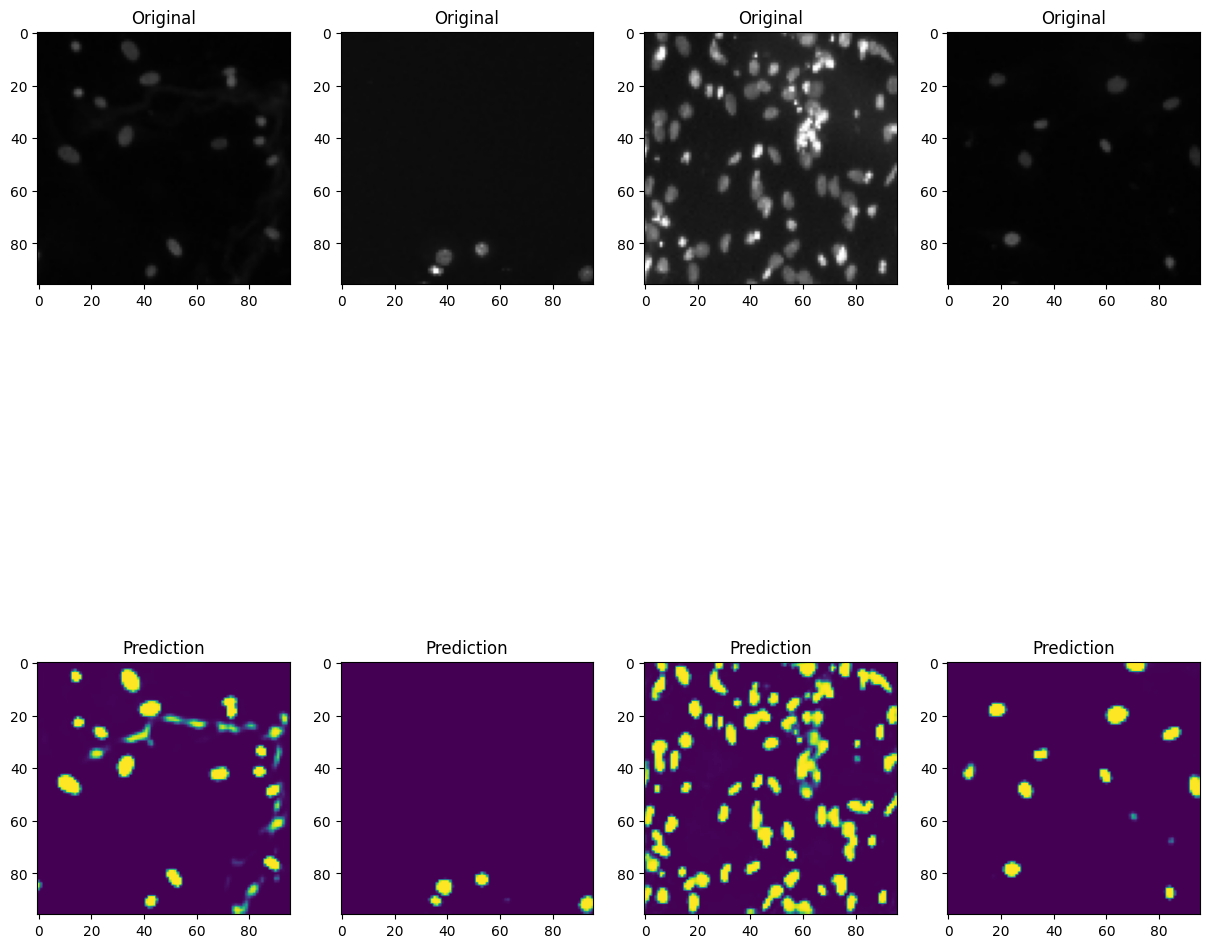

In [ ]:
# create model
print("=> creating model %s" % arch)
model = archs.__dict__[arch](num_classes,input_channels,deep_supervision)

model = model

# Data loading code
img_ids = glob(os.path.join('inputs', dataset, 'images', '*' + img_ext))
img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_ids]

_, val_img_ids = train_test_split(img_ids, test_size=0.2, random_state=41)

model.load_state_dict(torch.load('models/dsb2018_96_NestedUNet_woDS/model.pth'))
model.eval()

val_transform = Compose([
    transforms.Normalize(),
])

val_dataset = Dataset(
    img_ids=val_img_ids,
    img_dir=os.path.join('inputs', dataset, 'images'),
    mask_dir=os.path.join('inputs', dataset, 'masks'),
    img_ext=img_ext,
    mask_ext=mask_ext,
    num_classes=num_classes,
    transform=val_transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False)

avg_meter = AverageMeter()

for c in range(num_classes):
    os.makedirs(os.path.join('outputs', 'dsb2018_96_NestedUNet_woDS', str(c)), exist_ok=True)
with torch.no_grad():
    display_imgs = []
    names = []
    plt.figure(figsize=(15,15))
    for input, target, meta in tqdm(val_loader, total=4):#len(val_loader)):
        # compute output
        if deep_supervision:
            output = model(input)[-1]
        else:
            output = model(input)

        iou = iou_score(output, target)
        avg_meter.update(iou, input.size(0))

        output = torch.sigmoid(output).cpu().numpy()



        for i in range(len(output)):
            for c in range(num_classes):
                pred_img = (output[i, c] * 255).astype('uint8')
                display_imgs.append(pred_img)
                names.append('inputs/dsb2018_96/images/'+meta['img_id'][i] + '.png')
                cv2.imwrite(os.path.join('outputs', 'dsb2018_96_NestedUNet_woDS', str(c), meta['img_id'][i] + '.jpg'),pred_img)

    l = 1
    m = 5
    for img in range(0,4):
      original_img = Image.open(names[img])
      plt.subplot(2,4,l)
      plt.imshow(original_img)
      plt.title('Original')

      plt.subplot(2,4,m)
      plt.imshow(display_imgs[img])
      plt.title('Prediction')
      l=l+1
      m=m+1


print('IoU: %.4f' % avg_meter.avg)